In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
data_csv = pd.read_csv('./data.csv', usecols=[1])

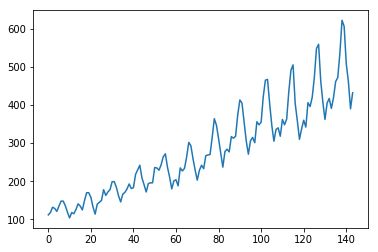

In [21]:
plt.plot(data_csv)

Đầu tiên chúng ta thực hiện tiền xử lý, loại bỏ `na` trong dữ liệu, và sau đó chuẩn hóa dữ liệu thành gía trị nằm giữa 0 và 1. 

CHÝ Ý: INPUT BẮT BUỘC PHẢI CÓ GÍA TRỊ NẰM GIỮA 0 VÀ 1

In [24]:
data_csv = data_csv.dropna()
dataset = data_csv.values
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: x / scalar, dataset))
dataset[0:2]

[array([0.21621622], dtype=float32), array([0.22779922], dtype=float32)]

Sau đó, ta tạo tập dữ liệu. Ta muốn dự đoán lưu lượng truy cập của tháng hiện tại thông qua lưu lượng truy cập của các tháng trước. Lưu lượng của tháng được coi là đầu ra. Đồng thời, chúng ta cần phải chia dữ liệu của chúng ta thành tập train và tập test.

Ở đây, ta muốn dự đoán lưu lượng truy cập của tháng hiện tại thông qua lưu lượng truy cập của hai tháng trước. Do đó, ta chọn ``look_back=2``

In [26]:
def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

data_X, data_Y = create_dataset(dataset)
data_X[0:2,]

array([[[0.21621622],
        [0.22779922]],

       [[0.22779922],
        [0.25482625]]], dtype=float32)

In [27]:
data_Y[0:2]

array([[0.25482625],
       [0.24903475]], dtype=float32)

chọn kích cỡ dữ liệu train là 70% toàn bộ dữ liệu

In [29]:
train_size = int(len(data_X) * 0.7)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

最后，我们需要将数据改变一下形状，因为 RNN 读入的数据维度是 (seq, batch, feature)，所以要重新改变一下数据的维度，这里只有一个序列，所以 batch 是 1，而输入的 feature 就是我们希望依据的几个月份，这里我们定的是两个月份，所以 feature 就是 2.

Cuối cùng, chúng ta cần phải thay đổi hình dạng của dữ liệu theo yêu cầu của pytorch đối với input RNN là (seq, batch, feature), do đó, để thay đổi kích thước của dữ liệu, chỉ có một chuỗi, vì vậy lô là 1, và tính năng đầu vào là Chúng tôi hy vọng rằng trong vài tháng, chúng tôi sẽ thiết lập hai tháng ở đây, vì vậy tính năng là 2.

Do đó, ta reshape dữ liệu và chuyển định dạng sang tensor

In [31]:
import torch

train_X = train_X.reshape(-1, 1, 2)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 2)

train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
test_x = torch.from_numpy(test_X)
train_x[0:3,]

tensor([[[0.2162, 0.2278]],

        [[0.2278, 0.2548]],

        [[0.2548, 0.2490]]])

In [33]:
train_y[0:3]

tensor([[[0.2548]],

        [[0.2490]],

        [[0.2336]]])

In [34]:
from torch import nn
from torch.autograd import Variable

这里定义好模型，模型的第一部分是一个两层的 RNN，每一步模型接受两个月的输入作为特征，得到一个输出特征。接着通过一个线性层将 RNN 的输出回归到流量的具体数值，这里我们需要用 `view` 来重新排列，因为 `nn.Linear` 不接受三维的输入，所以我们先将前两维合并在一起，然后经过线性层之后再将其分开，最后输出结果。

Mô hình được định nghĩa ở đây Phần đầu tiên của mô hình là một RNN hai lớp Mỗi mô hình bước chấp nhận hai tháng đầu vào như các tính năng để có được một tính năng đầu ra. Sau đó chúng ta trả về đầu ra của RNN với giá trị cụ thể của luồng thông qua một lớp tuyến tính. Ở đây chúng ta cần sắp xếp lại nó bằng `view`, vì` nn.Linear` không chấp nhận đầu vào 3D, vì vậy chúng ta hợp nhất hai thứ nguyên đầu tiên lại với nhau. Sau đó đi qua lớp tuyến tính và sau đó tách nó ra, và cuối cùng xuất kết quả.

In [35]:
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1,
                 num_layers=2):
        super(lstm_reg, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.reg = nn.Linear(hidden_size, output_size) # 回归
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        # Định dạng đầu vào được chuyển đổi thành lớp tuyến tính:
        x = x.view(s*b, h) 
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

In [36]:
net = lstm_reg(2, 4)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

Xác định cấu trúc mạng, kích thước đầu vào là 2, bởi vì ta sử dụng hai tháng lưu lượng truy cập làm đầu vào. Kích thước lớp ẩn có thể được chỉ định tùy ý, ở đây ta chọn 4

bắt đầu train:

In [37]:
for e in range(1000):
    var_x = Variable(train_x)
    var_y = Variable(train_y)
    # 前向传播
    out = net(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # 每 100 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.data[0]))

/home/thu/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:12: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number
  if sys.path[0] == '':


Epoch: 100, Loss: 0.00384
Epoch: 200, Loss: 0.00338
Epoch: 300, Loss: 0.00352
Epoch: 400, Loss: 0.00149
Epoch: 500, Loss: 0.00089
Epoch: 600, Loss: 0.00073
Epoch: 700, Loss: 0.00062
Epoch: 800, Loss: 0.00054
Epoch: 900, Loss: 0.00051
Epoch: 1000, Loss: 0.00058


Sau khi hoàn tất train, ta validate và sử dụng mô hình đã train để dự đoán kết quả 

In [39]:
# đánh giá mô hình 
net = net.eval() 

lstm_reg(
  (rnn): LSTM(2, 4, num_layers=2)
  (reg): Linear(in_features=4, out_features=1, bias=True)
)

In [40]:
data_X = data_X.reshape(-1, 1, 2)
data_X = torch.from_numpy(data_X)
var_data = Variable(data_X)
pred_test = net(var_data) # 测试集的预测结果 Kết quả dự đoán bộ thử nghiệm

In [41]:
# Thay đổi định dạng đầu ra
pred_test = pred_test.view(-1).data.numpy()

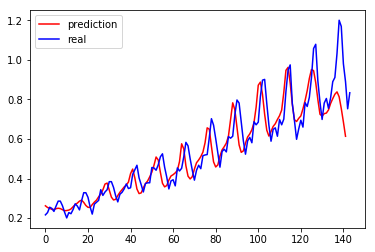

In [42]:
# Vẽ kết quả thực tế và kết quả dự đoán
plt.plot(pred_test, 'r', label='prediction')
plt.plot(dataset, 'b', label='real')
plt.legend(loc='best')

Ở đây màu xanh là tập dữ liệu thực, màu đỏ là kết quả dự đoán, chúng ta có thể thấy rằng sử dụng lstm có thể nhận được kết quả tương tự, xu hướng dự đoán cũng giống như tập dữ liệu thực, vì nó có thể nhớ trước Thông tin.

bạn có thể thử thay đổi số lượng neuron trong hidden layer để xem underfit, overfit như thế nào